In [1]:
import sys
sys.path.insert(0, "..")

import os, glob
import yaml
from pathlib import Path
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import numpy as np
import cv2

from torchvision.transforms import Compose, Resize, Normalize, ToTensor, Lambda
from torchvision.transforms import ColorJitter, RandomAffine, RandomPerspective, RandomRotation, RandomErasing, RandomCrop, Grayscale
from torchvision.transforms import RandomChoice, RandomApply
import torch
from torch.utils.data import DataLoader

from cutmix.cutmix import CutMix
from cutmix.utils import CutMixCrossEntropyLoss

from utils.data import CustomImageDataset
from utils.log import TextDocument
from utils.models import get_model

In [2]:
#with open('../data.yaml', 'r') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
#    data = yaml.load(file, Loader=yaml.FullLoader)

In [3]:
NUM_CLASSES = 4 #data["num_classes"]
RESUME = False
epochs = 100
IMG_SIZE = 640
BATCH_SIZE = 1
WEIGHTS_DIR = "../weights"
CUTMIX = True

Path(WEIGHTS_DIR).mkdir(exist_ok=True, parents=True)

In [4]:


def get_train_grayscale_transforms(img_size: int) -> Compose:
    """Returns data transformations/augmentations for train dataset.
    
    Args:
        img_size: The resolution of the input image (img_size x img_size)
    """
    return Compose([
        RandomApply([
            ColorJitter(brightness=0.3, contrast=0.01, saturation=0.01, hue=0),
            RandomAffine(0.1, translate=(0.04,0.04), scale=(0.04,0.04), shear=0.01, resample=2),
            RandomCrop(30),
            RandomPerspective(0.1)
        ]),
        Resize([img_size, img_size], interpolation=3),
        ToTensor(),
        Normalize(
            mean=[0.5203580774185134],
            std=[0.24102417452995067])
    ])
def get_test_grayscale_transforms(img_size: int) -> Compose:
    """Returns data transformations/augmentations for train dataset.
    
    Args:
        img_size: The resolution of the input image (img_size x img_size)
    """
    return Compose([
        Resize([img_size, img_size], interpolation=3),
        ToTensor(),
        Normalize(
            mean=[0.5203580774185134],
            std=[0.24102417452995067])
    ])

def show_confusion_matrix(matrix: List[List], labels: List[str]):
    """Display a nice confusion matrix given
    the confusion matrix in a 2D list + list of labels (decoder)
    
    Args:
        matrix: 2D array containing the values to display (confusion matrix)
        labels: Array containing the labels (indexed by corresponding label idx)
    """
    fig, ax = plt.subplots()
    fig.set_figheight(20)
    fig.set_figwidth(20)

    min_val, max_val = 0, len(labels)

    for i in range(max_val):
        for j in range(max_val):
            c = matrix[i][j]
            ax.text(i, j, str(int(c)), va='center', ha='center')

    ax.matshow(matrix, cmap=plt.cm.Blues)

    # Set number of ticks for x-axis
    ax.set_xticks(np.arange(max_val))
    # Set ticks labels for x-axis
    ax.set_xticklabels(labels, rotation='vertical', fontsize=16)

    # Set number of ticks for x-axis
    ax.set_yticks(np.arange(max_val))
    # Set ticks labels for x-axis
    ax.set_yticklabels(labels, rotation='horizontal', fontsize=16)
                    
    #ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val - 0.5, min_val - 0.5)
    plt.show()
    
def display_missclassified(class_to_idx: Dict[str,int], 
                           targets: List[int], 
                           predictions: List[int], 
                           images: List[np.ndarray], 
                           gridsize: Tuple[int] = (4,4)):
    """Display a grid with missclassified samples from test set.
    
    Args:
        class_to_idx: Class to idx encoder
        targets:      List containing all ground truths
        predictions:  List containing all predictions
        images:       List containing image arrays
        gridsize:     Tuple describing the final image grid
    """
    fig = plt.figure()
    plot_counter = 1
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    idx_to_class = {i:label for i, label in enumerate(class_to_idx)}
    for i in range(len(targets)):
        if plot_counter > gridsize[0]*gridsize[1]:
            break
        
        image = images[i].transpose(1, 2, 0)
        image = ((image * std) + mean) * 255
        image = image.astype("uint8")
    
        image = cv2.resize(image, (128, 128))
        image = cv2.putText(image, idx_to_class[predictions[i]], (0,20), 3, 0.4, (0,0,255), 1)
        if predictions[i] == targets[i]:
            pass
        else:
            ax = fig.add_subplot(gridsize[0], gridsize[1], plot_counter)
            ax.imshow(image)
            plot_counter += 1
    plt.show()
    


In [5]:
def train_one_epoch(model, train_dataloader, device, accumulate_steps=1):
    model.train()
    results = {
        "running_loss": 0
    }
    t = tqdm(train_dataloader)
    for i, (X, y) in enumerate(t):
        

        X = X.to(device)
        y = y.to(device)

        preds = model(X)
        loss = criterion(preds, y)
        
        results["running_loss"] += loss.cpu().detach()
        loss = loss/accumulate_steps
        loss.backward()
        
        if ((i+1) % accumulate_steps) == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        t.set_description(f"{epoch+1}/{epochs} Train: {round(float(running_loss)/(i+1), 4)}")
    optimizer.step()
    optimizer.zero_grad()
    
    return results

def evaluate_model(model, valid_dataloader, device, save_images=False):
    results = {
        "running_loss": 0,
        "targets": list(),
        "predictions": list()
    }    

    model.eval()
    with torch.no_grad():

        if save_images:
            results["images"] = list() 
            
        t = tqdm(valid_dataloader)
        for i, (X, y) in enumerate(t):
            X = X.to(device)
            y = y.to(device)

            preds = model(X)
            results["predictions"] += list(preds.argmax(axis=1).cpu().detach().numpy())
            results["targets"] += list(np.array(y.cpu()))
            if save_images:
                results["images"] += list(np.array(X.cpu()))
        
            loss = criterion(preds, y)

            running_loss += loss.cpu().detach()
            t.set_description(f"Test: {round(float(running_loss/(i+1)), 4)}")
            
    return results

def calculate_metrics():
    pass

In [6]:
train_imgs = glob.glob("/home/david/Documents/Datasets/train_test_classification_quarter_size/train/*/*.jpg")
valid_imgs = glob.glob("/home/david/Documents/Datasets/train_test_classification_quarter_size/valid/*/*.jpg")


train_labels = set([os.path.basename(os.path.dirname(img_path)) for img_path in train_imgs])
valid_labels = set([os.path.basename(os.path.dirname(img_path)) for img_path in valid_imgs])
class_to_idx = {label: idx for idx, label in enumerate(train_labels)}
train_dataset = CustomImageDataset(train_imgs, get_test_grayscale_transforms(IMG_SIZE), train_labels)
if CUTMIX:
    train_dataset = CutMix(train_dataset, num_class=NUM_CLASSES, beta=1.0, prob=0.5, num_mix=2)    # this is paper's original setting for cifar.

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=4)

valid_dataset = CustomImageDataset(valid_imgs, get_test_grayscale_transforms(IMG_SIZE), valid_labels)
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=4)

/home/david/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [10]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

from utils.models import get_resnet18, get_efficientnetb0, CSPResNet50, EfficientNetB8


results = TextDocument("results.txt")
results.add_line(f"acc f1 recall precision valid_loss train_loss")

# Using gpu or not
CUDA = "cuda" if torch.cuda.is_available() else "cpu"
if CUDA == "cuda":
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print(f"Using CPU")
#model = get_efficientnetb0(NUM_CLASSES, num_channels=1)
#model = get_resnet18(NUM_CLASSES, num_channels=1)

#model = CSPResNet50(NUM_CLASSES, num_channels=1)
#model.freeze_all_layers()
#model.unfreeze_new_layers()
model = get_model("resnet18d", num_classes=NUM_CLASSES, input_channels=1)


#model = get_ghostnet(NUM_CLASSES)
model.to(CUDA)
print(list(class_to_idx.keys()))

optimizer = torch.optim.Adam(model.parameters())
if CUTMIX:
    criterion = CutMixCrossEntropyLoss(True)
else:
    criterion = torch.nn.CrossEntropyLoss()
    
if RESUME:
    start_epoch = state_dict["epoch"]
    optimizer_state_dict = state_dict["optimizer_state_dict"]
    best_test_f1 = state_dict["best_test_f1"]

    model.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
else:
    best_test_f1 = 0
    start_epoch = 0

for epoch in range(start_epoch, epochs):
    if epoch == 2:
        model.unfreeze_all_layers()
        
        
    # Train one epoch    
    results = train_one_epoch(model, train_dataloader, CUDA, accumulate_steps=ACCUM_STEPS)
    train_loss = float(results["running_loss"]/(i+1))
    
    
    if epoch+1 == epochs:
        results = evaluate_model(model, valid_dataloader, CUDA, save_images=True)
        images = results["images"]
    else:
        results = evaluate_model(model, save_images=False)
            
    valid_loss = float(results["running_loss"]/(i+1))
    acc = accuracy_score(results["targets"], results["predictions"])
    f1 = f1_score(results["targets"], results["predictions"], average="macro", labels=np.unique(results["predictions"]))
    recall = recall_score(results["targets"], results["predictions"], average="macro", labels=np.unique(results["predictions"]))
    precision = precision_score(results["targets"], results["predictions"], average="macro", labels=np.unique(results["predictions"]))
    
    
    
    


    

    show_confusion_matrix(confusion_matrix(targets, predictions), list(class_to_idx.keys()))
    
    
    
    
    
    if f1 > best_test_f1:
        best_test_f1 = f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_test_f1': best_test_f1,
            'train_dataloader': train_dataloader,
            'test_dataloader': valid_dataloader,
            'class_to_idx': class_to_idx
        }, os.path.join(WEIGHTS_DIR, "best.pt"))

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_test_f1': best_test_f1,
    'train_dataloader': train_dataloader,
    'test_dataloader': valid_dataloader,
    'class_to_idx': class_to_idx,
}, os.path.join(WEIGHTS_DIR, "last.pt"))

display_missclassified(class_to_idx, targets, predictions, images, gridsize=(4,4))
show_confusion_matrix(confusion_matrix(targets, predictions), list(class_to_idx.keys()))

Using GPU: NVIDIA GeForce RTX 3080
['indeterminate', 'atypical', 'typical', 'negative']


NameError: name 'ACCUM_STEPS' is not defined

In [8]:

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_test_f1': best_test_f1,
    'train_dataloader': train_dataloader,
    'test_dataloader': valid_dataloader,
    'class_to_idx': class_to_idx,
}, os.path.join(WEIGHTS_DIR, "last.pt"))

display_missclassified(class_to_idx, targets, predictions, images, gridsize=(4,4))
show_confusion_matrix(confusion_matrix(targets, predictions), list(class_to_idx.keys()))

NameError: name 'epoch' is not defined

In [9]:
model = get_efficientnetb0(NUM_CLASSES, num_channels=1)
state_dict = torch.load(os.path.join("../weights", "best.pt"))
model.load_state_dict(state_dict["model_state_dict"])     
model.to(CUDA)

model.eval()
with torch.no_grad():
    predictions = list() # For display purpose
    targets = list() # For display purpose
    if epoch+1 == epochs:
        images = list() # For display purpose
    running_loss = 0
    t = tqdm(valid_dataloader)
    for i, (X, y) in enumerate(t):
        X = X.to(CUDA)
        y = y.to(CUDA)

        preds = model(X)
        predictions += list(preds.argmax(axis=1).cpu().detach().numpy())
        targets += list(np.array(y.cpu()))
        if epoch+1 == epochs:
            images += list(np.array(X.cpu()))

        loss = criterion(preds, y)

        running_loss += loss.cpu().detach()
        t.set_description(f"Test: {round(float(running_loss/(i+1)), 4)}")

acc = accuracy_score(targets, predictions)
f1 = f1_score(targets, predictions, average="macro", labels=np.unique(predictions))
recall = recall_score(targets, predictions, average="macro", labels=np.unique(predictions))
precision = precision_score(targets, predictions, average="macro", labels=np.unique(predictions))
print(f"Test: Acc: {str(acc)[:5]}, F1: {str(f1)[:5]}, Recall: {str(recall)[:5]}, Precision: {str(precision)[:5]}\n")

NameError: name 'get_efficientnetb0' is not defined

In [10]:
display_missclassified(class_to_idx, targets, predictions, images, gridsize=(4,4))
show_confusion_matrix(confusion_matrix(targets, predictions), list(class_to_idx.keys()))

NameError: name 'targets' is not defined

In [8]:
import timm

from utils.models import EfficientNetB8

model = EfficientNetB8(NUM_CLASSES, num_channels=1)
#model = timm.create_model("cspresnet50")

def recursive_iterate_modules(current_module, prefix=''):
    for name, module in current_module.named_modules():
        for i in range(10):
            name = name.replace(f'.{i}.', f'[{i}].')
        if name.endswith(".bn"):
            exec(f"{'model' + '.' + name}.momentum = 0.01")
def recursive_iterate_print_modules(current_module, prefix=''):
    for name, module in current_module.named_modules():
        #print(name)
        if name.endswith(".bn"):
            print(module)
recursive_iterate_modules(model)
recursive_iterate_print_modules(model)

In [9]:
# stages.0.blocks.0.conv1.bn.act
# model.stages[0].blocks[0].conv1.bn.act

name = "stages.0.blocks.0.conv1.bn"

exec(f"print('model' + '.' + name.replace('.0.', '[0].') )")
#exec(f"print('model' + '.' + name.replace('.0.', '[0].') + ' = ' + '' )")
#model


model.stages[0].blocks[0].conv1.bn


# Accumulated gradient

In [26]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

from utils.models import get_resnet18, get_efficientnetb0, CSPResNet50, EfficientNetB8
ACCUM_STEPS = 64
results = TextDocument("results_accum.txt")
results.add_line(f"acc f1 recall precision valid_loss train_loss")

# Using gpu or not
CUDA = "cuda" if torch.cuda.is_available() else "cpu"
if CUDA == "cuda":
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print(f"Using CPU")
#model = get_efficientnetb0(NUM_CLASSES, num_channels=1)
#model = get_resnet18(NUM_CLASSES, num_channels=1)

#model = CSPResNet50(NUM_CLASSES, num_channels=1)
#model.freeze_all_layers()
#model.unfreeze_new_layers()

model = get_model("resnet18d", num_classes=4, input_channels=1) #EfficientNetB8(NUM_CLASSES, num_channels=1)

#recursive_iterate_modules(model)
#recursive_iterate_print_modules(model)

#model = get_ghostnet(NUM_CLASSES)
model.to(CUDA)
print(list(class_to_idx.keys()))

if RESUME:
    optimizer, criterion = get_training_stuff(model)
else:
    #weights = torch.Tensor(weights).to(CUDA)
    #optimizer, criterion = get_training_stuff(model, weights=weights)
    optimizer = torch.optim.Adam(model.parameters())
    if CUTMIX:
        criterion = CutMixCrossEntropyLoss(True)
    else:
        criterion = torch.nn.CrossEntropyLoss()
    
if RESUME:
    start_epoch = state_dict["epoch"]
    optimizer_state_dict = state_dict["optimizer_state_dict"]
    best_test_f1 = state_dict["best_test_f1"]

    model.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
else:
    best_test_f1 = 0
    start_epoch = 0

for epoch in range(start_epoch, epochs):      
        
    results = train_one_epoch(model, train_dataloader, CUDA, accumulate_steps=ACCUM_STEPS)
    train_loss = float(results["running_loss"]/(i+1))
    
    if epoch+1 == epochs:
        results = evaluate_model(model, valid_dataloader, CUDA, save_images=True)
        images = results["images"]
    else:
        results = evaluate_model(model, save_images=False)
    
    valid_loss = float(results["running_loss"]/(i+1))
    acc = accuracy_score(results["targets"], results["predictions"])
    f1 = f1_score(results["targets"], results["predictions"], average="macro", labels=np.unique(results["predictions"]))
    recall = recall_score(results["targets"], results["predictions"], average="macro", labels=np.unique(results["predictions"]))
    precision = precision_score(results["targets"], results["predictions"], average="macro", labels=np.unique(results["predictions"]))
    
    print(f"Test: Acc: {str(acc)[:5]}, F1: {str(f1)[:5]}, Recall: {str(recall)[:5]}, Precision: {str(precision)[:5]}\n")
    results.add_line(f"{float(acc)} {float(f1)} {float(recall)} {float(precision)} {valid_loss} {train_loss}")
    
    show_confusion_matrix(confusion_matrix(targets, predictions), list(class_to_idx.keys()))
    
    if f1 > best_test_f1:
        best_test_f1 = f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_test_f1': best_test_f1,
            'train_dataloader': train_dataloader,
            'test_dataloader': valid_dataloader,
            'class_to_idx': class_to_idx
        }, os.path.join(WEIGHTS_DIR, "best.pt"))

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_test_f1': best_test_f1,
    'train_dataloader': train_dataloader,
    'test_dataloader': valid_dataloader,
    'class_to_idx': class_to_idx,
}, os.path.join(WEIGHTS_DIR, "last.pt"))

display_missclassified(class_to_idx, targets, predictions, images, gridsize=(4,4))
show_confusion_matrix(confusion_matrix(targets, predictions), list(class_to_idx.keys()))

Using GPU: NVIDIA GeForce RTX 3080


  0%|          | 0/5334 [00:00<?, ?it/s]

['atypical', 'negative', 'indeterminate', 'typical']


  0%|          | 0/5334 [00:00<?, ?it/s]


RuntimeError: CUDA error: no kernel image is available for execution on the device

# Accumilated gradient with cutmix

Using GPU: GeForce RTX 3080


  0%|                                                                                         | 0/5334 [00:00<?, ?it/s]

['typical', 'negative', 'atypical', 'indeterminate']


Test: 3.5792: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:49<00:00, 20.21it/s]


Test: Acc: 0.38, F1: 0.161, Recall: 0.210, Precision: 0.160



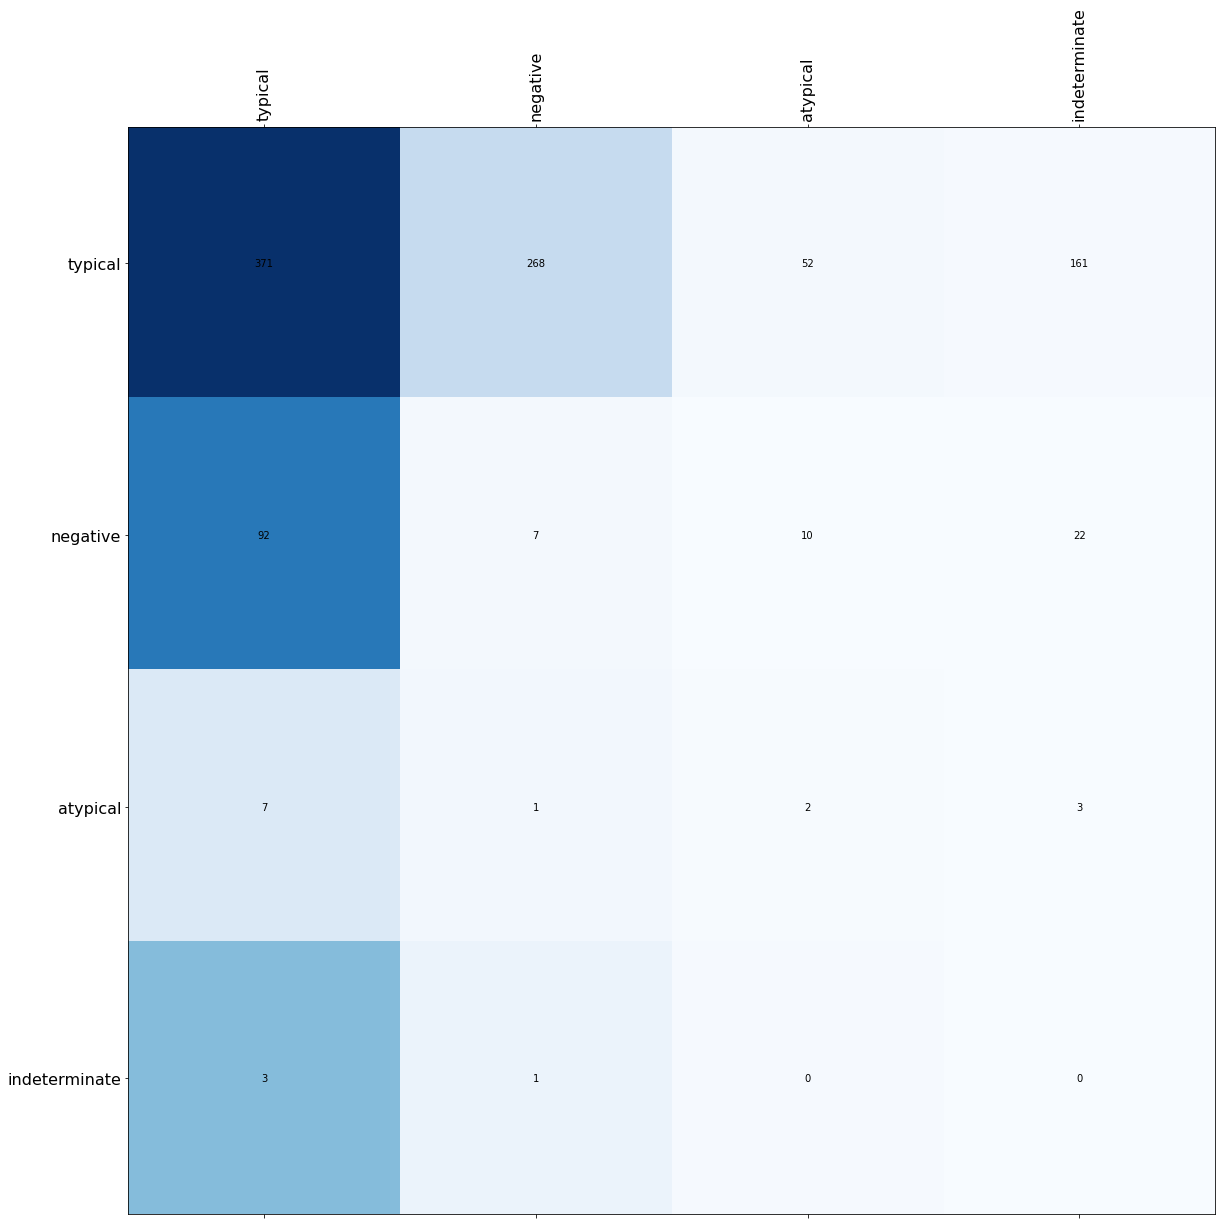

Test: 1.8748: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:49<00:00, 20.19it/s]


Test: Acc: 0.389, F1: 0.199, Recall: 0.234, Precision: 0.308



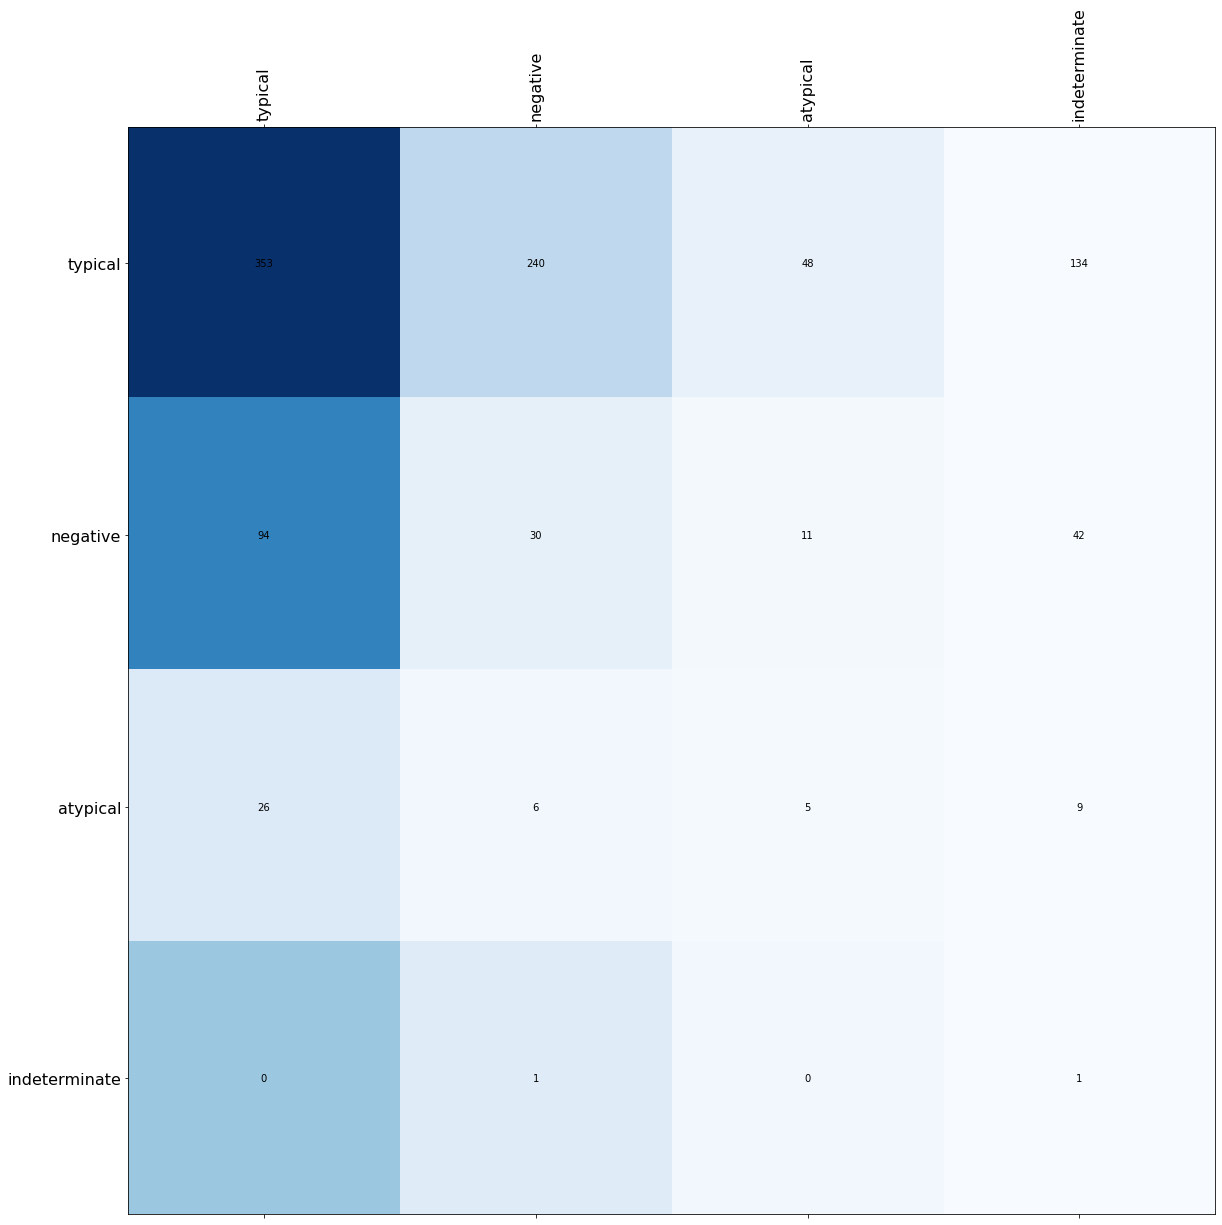

Test: 1.5799: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.68it/s]


Test: Acc: 0.415, F1: 0.234, Recall: 0.284, Precision: 0.238



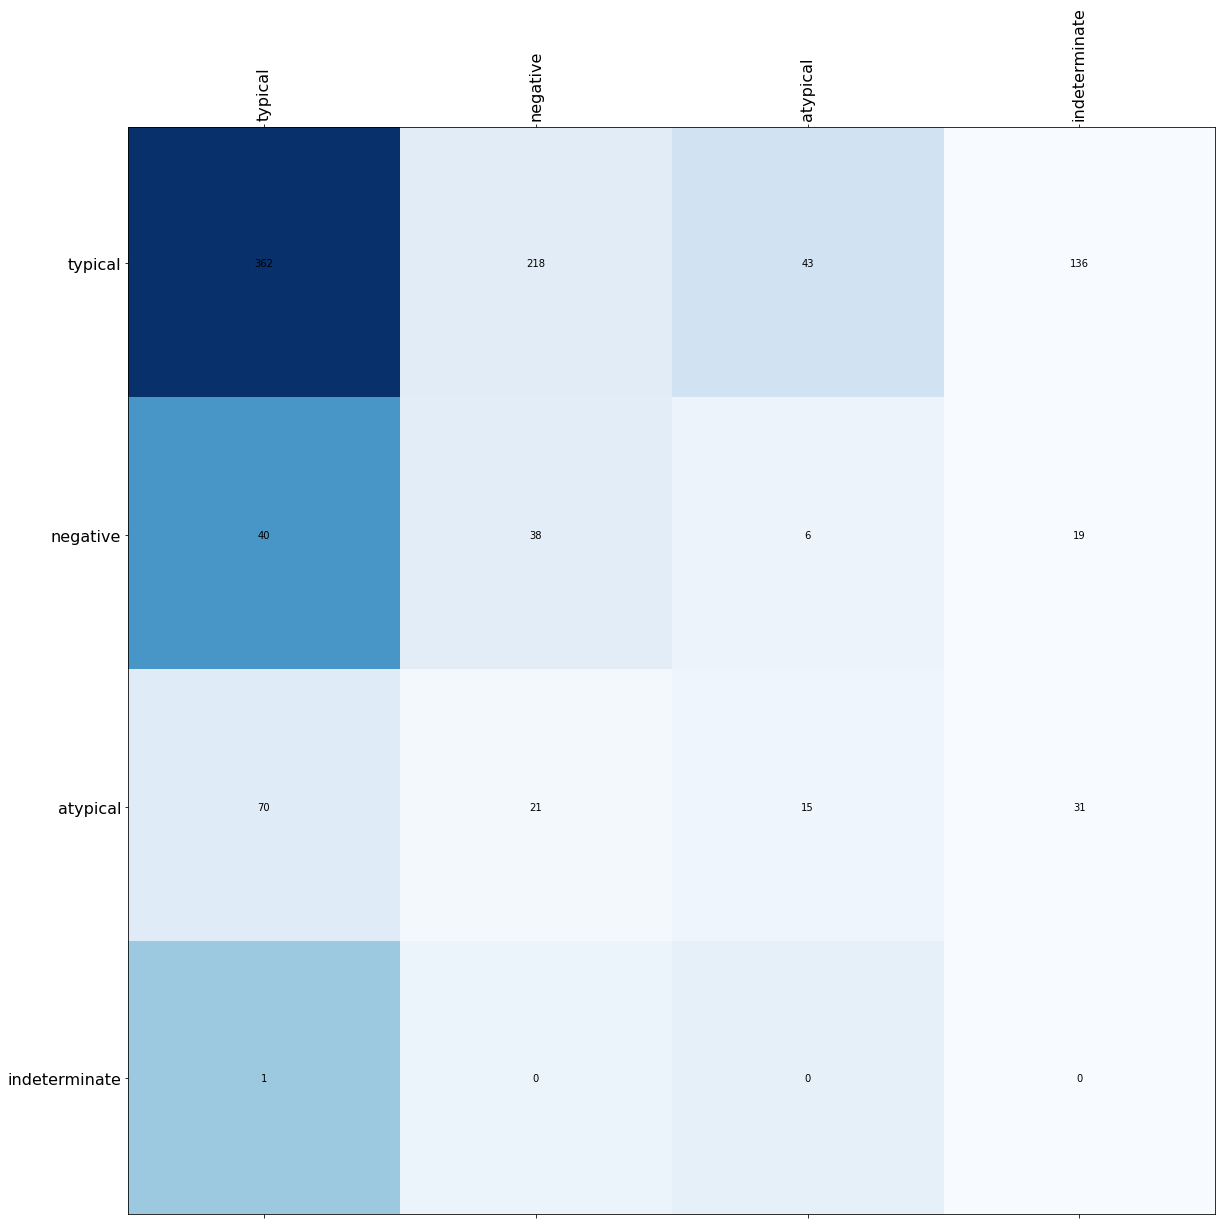

Test: 2.4866: 100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:50<00:00, 19.63it/s]


Test: Acc: 0.372, F1: 0.195, Recall: 0.252, Precision: 0.179



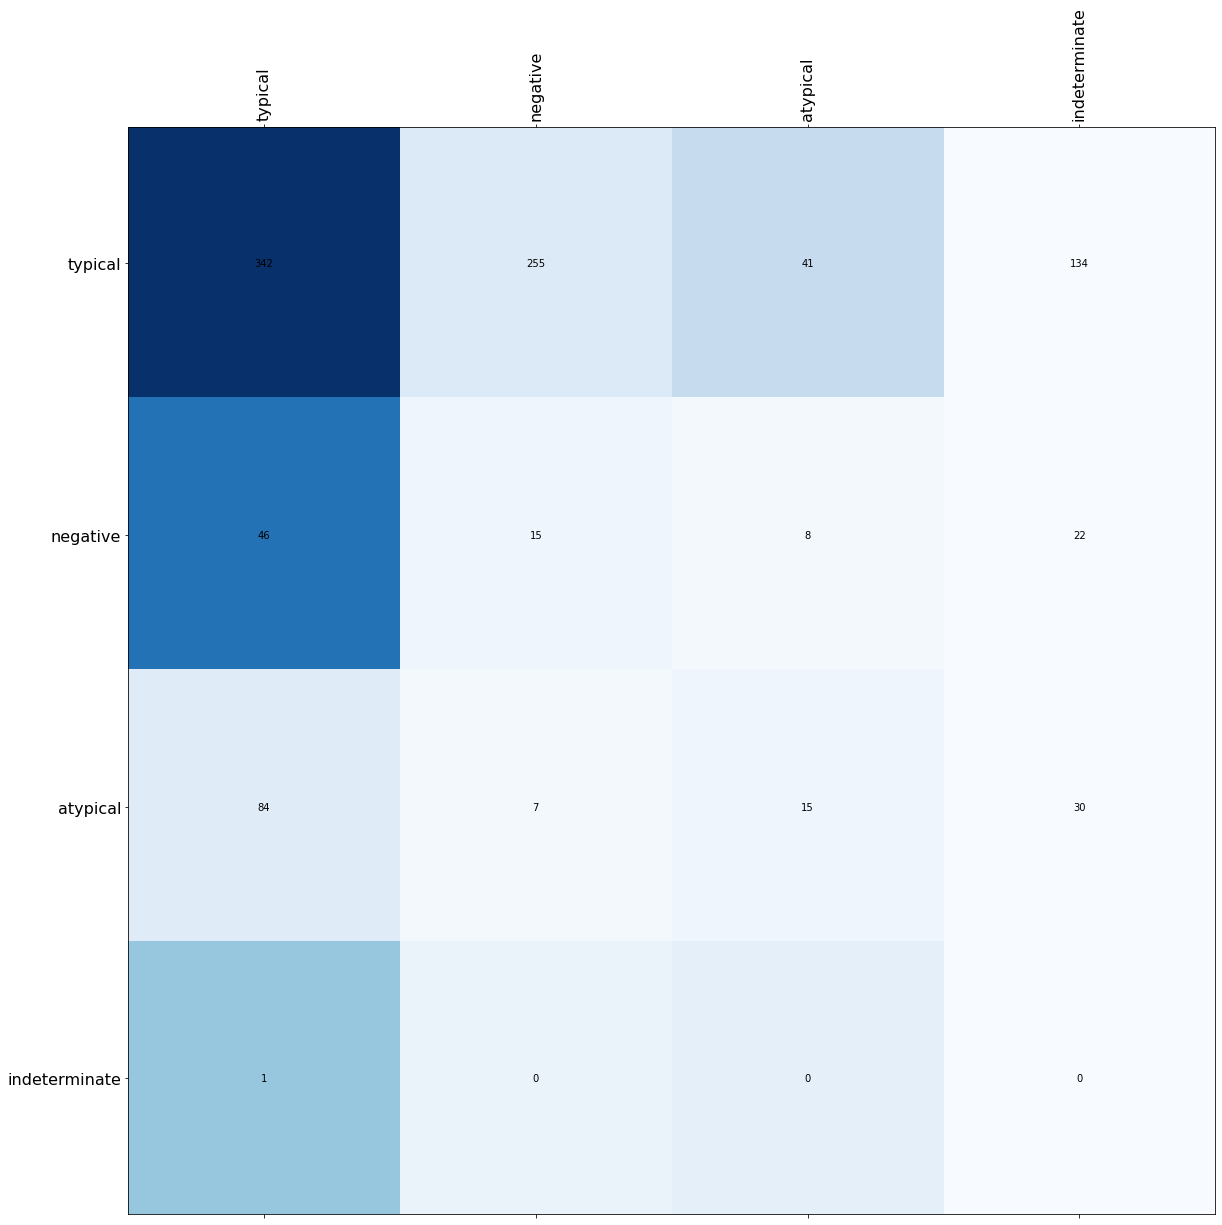

Test: 3.0764:  61%|███████████████████████████████████████▊                         | 613/1000 [00:31<00:17, 22.73it/s]

In [ ]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

from utils.models import get_resnet18, get_efficientnetb0, CSPResNet50, EfficientNetB8

train_imgs = glob.glob("E:/Dataset/train_test_classification_quarter_size/train/*/*.jpg")
valid_imgs = glob.glob("E:/Dataset/train_test_classification_quarter_size/valid/*/*.jpg")


train_labels = set([os.path.basename(os.path.dirname(img_path)) for img_path in train_imgs])
valid_labels = set([os.path.basename(os.path.dirname(img_path)) for img_path in valid_imgs])
class_to_idx = {label: idx for idx, label in enumerate(train_labels)}
train_dataset = CustomImageDataset(train_imgs, get_test_grayscale_transforms(IMG_SIZE), train_labels)

train_dataset = CutMix(train_dataset, num_class=NUM_CLASSES, beta=1.0, prob=0.5, num_mix=2)    # this is paper's original setting for cifar.


valid_dataset = CustomImageDataset(valid_imgs, get_test_grayscale_transforms(IMG_SIZE), valid_labels)
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=4)





ACCUM_STEPS = 64
results = TextDocument("results_accum_fat_model.txt")
results.add_line(f"acc f1 recall precision valid_loss train_loss")

# Using gpu or not
CUDA = "cuda" if torch.cuda.is_available() else "cpu"
if CUDA == "cuda":
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print(f"Using CPU")
#model = get_efficientnetb0(NUM_CLASSES, num_channels=1)
#model = get_resnet18(NUM_CLASSES, num_channels=1)

#model = CSPResNet50(NUM_CLASSES, num_channels=1)
#model.freeze_all_layers()
#model.unfreeze_new_layers()

model = EfficientNetB8(NUM_CLASSES, num_channels=1)

recursive_iterate_modules(model)
recursive_iterate_print_modules(model)

#model = get_ghostnet(NUM_CLASSES)
model.to(CUDA)
print(list(class_to_idx.keys()))

if RESUME:
    optimizer, criterion = get_training_stuff(model)
else:
    #weights = torch.Tensor(weights).to(CUDA)
    #optimizer, criterion = get_training_stuff(model, weights=weights)
    optimizer = torch.optim.Adam(model.parameters())
    if CUTMIX:
        criterion = CutMixCrossEntropyLoss(True)
    else:
        criterion = torch.nn.CrossEntropyLoss()
    
if RESUME:
    start_epoch = state_dict["epoch"]
    optimizer_state_dict = state_dict["optimizer_state_dict"]
    best_test_f1 = state_dict["best_test_f1"]

    model.load_state_dict(state_dict["model_state_dict"])
    optimizer.load_state_dict(state_dict["optimizer_state_dict"])
else:
    best_test_f1 = 0
    start_epoch = 0

for epoch in range(start_epoch, epochs):

    model.train()
    running_loss = 0
    t = tqdm(train_dataloader)
    for i, (X, y) in enumerate(t):

        X = X[0].unsqueeze(0).to(CUDA)
        y = y[0].unsqueeze(0).to(CUDA)

        preds = model(X)
        loss = criterion(preds, y)
        
        running_loss += loss.cpu().detach()
        loss = loss/ACCUM_STEPS
        loss.backward()
        
        if ((i+1) % ACCUM_STEPS) == 0:
            optimizer.step()
            optimizer.zero_grad()
            
        t.set_description(f"{epoch+1}/{epochs} Train: {round(float(running_loss)/(i+1), 4)}")
    optimizer.step()
    optimizer.zero_grad()        
        
        
    train_loss = float(running_loss/(i+1))
    model.eval()
    with torch.no_grad():
        predictions = list() # For display purpose
        targets = list() # For display purpose
        if epoch+1 == epochs:
            images = list() # For display purpose
        running_loss = 0
        t = tqdm(valid_dataloader)
        for i, (X, y) in enumerate(t):
            X = X.to(CUDA)
            y = y.to(CUDA)

            preds = model(X)
            predictions += list(preds.argmax(axis=1).cpu().detach().numpy())
            targets += list(np.array(y.cpu()))
            if epoch+1 == epochs:
                images += list(np.array(X.cpu()))
        
            loss = criterion(preds, y)

            running_loss += loss.cpu().detach()
            t.set_description(f"Test: {round(float(running_loss/(i+1)), 4)}")
    valid_loss = float(running_loss/(i+1))
    acc = accuracy_score(targets, predictions)
    f1 = f1_score(targets, predictions, average="macro", labels=np.unique(predictions))
    recall = recall_score(targets, predictions, average="macro", labels=np.unique(predictions))
    precision = precision_score(targets, predictions, average="macro", labels=np.unique(predictions))
    print(f"Test: Acc: {str(acc)[:5]}, F1: {str(f1)[:5]}, Recall: {str(recall)[:5]}, Precision: {str(precision)[:5]}\n")
    results.add_line(f"{float(acc)} {float(f1)} {float(recall)} {float(precision)} {valid_loss} {train_loss}")
    
    show_confusion_matrix(confusion_matrix(targets, predictions), list(class_to_idx.keys()))
    if f1 > best_test_f1:
        best_test_f1 = f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_test_f1': best_test_f1,
            'train_dataloader': train_dataloader,
            'test_dataloader': valid_dataloader,
            'class_to_idx': class_to_idx
        }, os.path.join(WEIGHTS_DIR, "best.pt"))

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_test_f1': best_test_f1,
    'train_dataloader': train_dataloader,
    'test_dataloader': valid_dataloader,
    'class_to_idx': class_to_idx,
}, os.path.join(WEIGHTS_DIR, "last.pt"))

display_missclassified(class_to_idx, targets, predictions, images, gridsize=(4,4))
show_confusion_matrix(confusion_matrix(targets, predictions), list(class_to_idx.keys()))

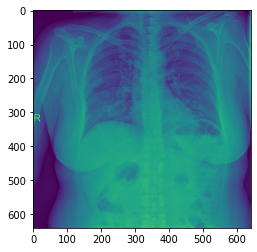

In [19]:
plt.imshow(X.cpu().numpy()[0][0])


In [ ]:
import yaml
data = {
    "pixel_mean": 0.5203580774185134,
    "pixel_std": 0.24102417452995067,
    "labels": ['negative', 'typical', 'indeterminate', 'atypical']
}


with open("output_file.yaml", "w") as file:
    yaml.dump(data, file)

In [ ]:
with open(r'output_file.yaml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    fruits_list = yaml.load(file, Loader=yaml.FullLoader)

    print(fruits_list)

In [ ]:
!ls ../../../Datasets/train_test_classification_full_size/train

In [ ]:
for a in data_loader:
    print(a)

In [ ]:
#!dir ..\..\..\Dataset\Covid19\classification_full_size\classification_full_size\train
!dir ..\..\..\Dataset\CIFAR-10-images\

In [1]:
import timm
timm.list_models()

['adv_inception_v3',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'cspdarknet53',
 'cspdarknet53_iabn',
 'cspresnet50',
 'cspresnet50d',
 'cspresnet50w',
 'cspresnext50',
 'cspresnext50_iabn',
 'darknet53',
 'densenet121',
 'densenet121d',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenet264',
 'densenet264d_iabn',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'eca_nfnet_l0',
 'eca_nfnet_l1',
 'eca_vovnet39b',
 'ecaresnet26t'

In [2]:
model = timm.create_model("cspresnet50")
model.head.fc = nn.Linear(in_features=1024, out_features=num_classes, bias=True)
model.stem.conv1.conv = Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

NameError: name 'nn' is not defined

In [8]:
import timm
model = timm.create_model("tf_efficientnet_b8", pretrained=True, in_chans=1).to("cuda")
model(torch.zeros(1,1,640,640).to("cuda"))
#timm.list_models(pretrained=True)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.00 GiB total capacity; 7.80 GiB already allocated; 0 bytes free; 7.91 GiB reserved in total by PyTorch)

In [ ]:
# Script to train different backbones, and save results and models based on test loss, accuracy, F1-score

In [3]:
import torch
CSPResNet50(num_classes=4, num_channels=1).load_state_dict(torch.load("../weights/best_CSPResNet50.pt")["model_state_dict"])

<All keys matched successfully>

In [2]:
import sys
sys.path.insert(0, "..")
from utils.models import CSPResNet50

CSPResNet50(num_classes=1)

CSPResNet50(
  (model): CspNet(
    (stem): Sequential(
      (conv1): ConvBnAct(
        (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (act): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (stages): Sequential(
      (0): CrossStage(
        (conv_exp): ConvBnAct(
          (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (act): Identity()
          )
        )
        (blocks): Sequential(
          (0): ResBottleneck(
            (conv1): ConvBnAct(
              (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNormAct2d(
     

In [9]:
timm.create_model("tf_efficientnet_b8", pretrained=True, in_chans=1).classifier = nn.Linear(in_features=2816, out_features=num_classes, bias=True)

EfficientNet(
  (conv_stem): Conv2dSame(1, 72, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(72, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=72, bias=False)
        (bn1): BatchNorm2d(72, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(72, 18, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(18, 72, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(72, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv